# Regression Models (Star Rating 2018-2019)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from category_encoders import OneHotEncoder 

In [2]:
data = pd.read_csv('../../01_data/cleaned_data/school_df_v6.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   code                         109 non-null    float64
 1   name                         109 non-null    object 
 2   grade_band                   109 non-null    object 
 3   enrollment_SY1718            109 non-null    float64
 4   enrollment_SY1819            109 non-null    float64
 5   star_score_SY1718            109 non-null    float64
 6   star_score_SY1819            109 non-null    float64
 7   star_rating_SY1718           109 non-null    float64
 8   star_rating_SY1819           109 non-null    float64
 9   capacity_SY1718              109 non-null    float64
 10  capacity_SY1819              109 non-null    float64
 11  latitude                     109 non-null    float64
 12  longitude                    109 non-null    float64
 13  cluster             

In [4]:
# drop unnamed columns and "bad import" full-nan rows
data = data.iloc[:,:45]
data.dropna(how='all', inplace=True)

In [5]:
# drop 2 schools that have no attendance data
data.drop(data[data['code'] == 201].index, inplace = True) # Oyster Adams Bilingual School (Adams) has no attendance data
data.drop(data[data['code'] == 347].index, inplace = True) # Brookland Middle School has no attendance data

In [6]:
# drop columns looking at "count" of absences (non-relatable across schools of different sizes)
X = data.drop(columns = data.filter(regex='^count',axis=1)).drop(columns='name')

In [7]:
# drop school_code
X.drop('code', axis = 1, inplace = True)

<br><br>

## Tailor DF to SY 1819 data

In [8]:
# drop columns looking at school year 17-18 and FY 16
X = X.drop(columns = X.filter(regex='SY1718$',axis=1)).drop(columns = data.filter(regex='FY16$',axis=1))

In [9]:
# OHE grade_band column
X_ohe = OneHotEncoder(cols=['grade_band']).fit_transform(X)

c:\programdata\miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


<br><br>

# Create no_nan_df
### Only looks at 82 rows
* Need a better solution for dealing with np.nan (originally cast as -1)

In [10]:
no_nan_df = X_ohe.replace(-1,np.nan)

In [11]:
no_nan_df.dropna(how='any',inplace=True)

In [12]:
no_nan_y = no_nan_df['star_rating_SY1819']
no_nan_X = no_nan_df.drop(columns=['star_score_SY1819','star_rating_SY1819'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(no_nan_X, no_nan_y)

<br><br>
# Regression Models

In [14]:
def print_results(grid, X_train, X_test, y_train, y_test):
    #print(f'Estimator : {grid.get_estimator_}')
    
    print('*** TRAIN set ***')
    print(f'Score : {grid.score(X_train, y_train)}')
    print(f'RMSE: {mean_squared_error(y_train, grid.predict(X_train), squared = False)}')
    print(f'MSE: {mean_squared_error(y_train, grid.predict(X_train))}')
    print()
    print('*** TEST set ***')
    print(f'Score : {grid.score(X_test, y_test)}')
    print(f'RMSE: {mean_squared_error(y_test, grid.predict(X_test), squared = False)}')
    print(f'MSE: {mean_squared_error(y_test, grid.predict(X_test))}')
    print()
    print(f'Best Params : {grid.best_params_}')

    y_pred = grid.predict(X_test)
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.scatter(y_test, y_pred)
    ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")
    #plt.title('')
    plt.xlabel('Star Rating')
    plt.ylabel('Model Predictions');

<br><br>

### Multiple Linear Regression Model

*** TRAIN set ***
Score : 1.0
RMSE: 6.705366596777549e-15
MSE: 4.496194119718013e-29

*** TEST set ***
Score : -7.921706688930369
RMSE: 3.2386008310654866
MSE: 10.48853534297806

Best Params : {'lr__normalize': 'True'}


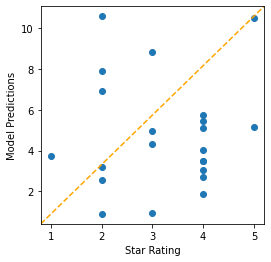

In [15]:
pipe = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('lr', LinearRegression())])
param = [
    {'lr__normalize': ['True','False']}
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)

<br><br>

### Ridge Model

*** TRAIN set ***
Score : 0.7566822959099055
RMSE: 0.5862364964869728
MSE: 0.34367322981332055

*** TEST set ***
Score : 0.43889302287304444
RMSE: 0.812187473250503
MSE: 0.6596484917050366

Best Params : {'ridge__alpha': 100}


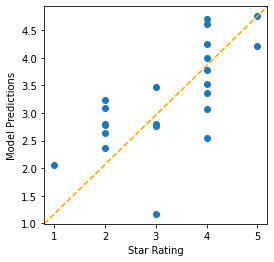

In [16]:
pipe1 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('ridge', Ridge())])
param1 = [
    {'ridge__alpha': [.01, .1, 1, 10, 100]}
]
grid1 = GridSearchCV(pipe1, param1, n_jobs = -1)
grid1.fit(X_train, y_train)
print_results(grid1, X_train, X_test, y_train, y_test)

<br><br>

### KNeighbors Model

*** TRAIN set ***
Score : 0.6219030377723986
RMSE: 0.7307815787633797
MSE: 0.5340417158598977

*** TEST set ***
Score : 0.4069340150183737
RMSE: 0.834997086962981
MSE: 0.6972201352366642

Best Params : {'knearest__n_neighbors': 11}


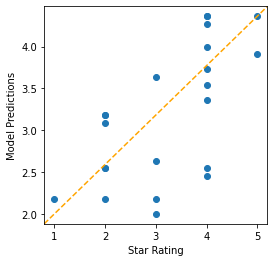

In [17]:
pipe2 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('knearest', KNeighborsRegressor())])
param2 = [
    {'knearest__n_neighbors': [3,7,11,25,35]}
]
grid2 = GridSearchCV(pipe2, param2, n_jobs = -1)
grid2.fit(X_train, y_train)
print_results(grid2, X_train, X_test, y_train, y_test)

<br><br>

### Decision Tree Model

*** TRAIN set ***
Score : 0.8304138423118088
RMSE: 0.48941941941733036
MSE: 0.2395313681027967

*** TEST set ***
Score : 0.5059064781936989
RMSE: 0.7621457501276072
MSE: 0.580866144437573

Best Params : {'dtree__ccp_alpha': 0.01, 'dtree__max_depth': 3, 'dtree__min_samples_leaf': 9, 'dtree__min_samples_split': 5}


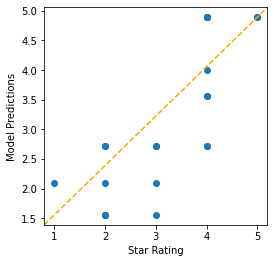

In [18]:
pipe3 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('dtree', DecisionTreeRegressor())])
param3 = [
    {'dtree__max_depth':[3,5,7,9],
    'dtree__min_samples_split':[3,5,7,9], 
    'dtree__min_samples_leaf':[3,5,7,9], 
    'dtree__ccp_alpha':[.01, .1, 1, 10, 100]}
]
grid3 = GridSearchCV(pipe3, param3, n_jobs = -1)
grid3.fit(X_train, y_train)
print_results(grid3, X_train, X_test, y_train, y_test)

<br><br>

### Bagged Decision Tree Model

*** TRAIN set ***
Score : 0.9509032886193365
RMSE: 0.2633371910507063
MSE: 0.06934647619047618

*** TEST set ***
Score : 0.6223831845342708
RMSE: 0.6662835869071203
MSE: 0.4439338181818181

Best Params : {'btree__n_estimators': 500}


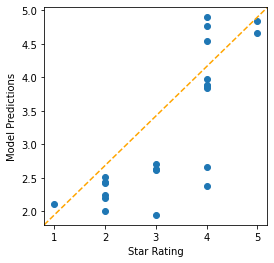

In [19]:
pipe4 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('btree', BaggingRegressor())])
param4 = [
    {'btree__n_estimators':[50, 100, 500]}
]
grid4 = GridSearchCV(pipe4, param4, n_jobs = -1)
grid4.fit(X_train, y_train)
print_results(grid4, X_train, X_test, y_train, y_test)

<br><br>

### Random Forest Model

*** TRAIN set ***
Score : 0.9147940059215071
RMSE: 0.3469133965596169
MSE: 0.12034890471253001

*** TEST set ***
Score : 0.5844144678502763
RMSE: 0.6989782504585065
MSE: 0.4885705946140347

Best Params : {'randforest__max_depth': 7, 'randforest__min_samples_leaf': 3, 'randforest__min_samples_split': 3, 'randforest__n_estimators': 50}


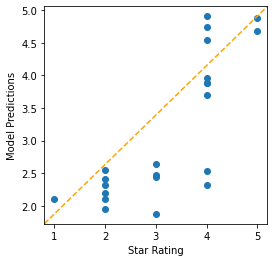

In [20]:
pipe5 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('randforest', RandomForestRegressor())])
param5 = [
    {'randforest__max_depth':[3,5,7,9],
    'randforest__min_samples_split':[3,5,7,9], 
    'randforest__min_samples_leaf':[3,5,7,9], 
    'randforest__n_estimators':[50, 100, 500]}
]
grid5 = GridSearchCV(pipe5, param5, n_jobs = -1)
grid5.fit(X_train, y_train)
print_results(grid5, X_train, X_test, y_train, y_test)

<br><br>

### Adaboost Model

*** TRAIN set ***
Score : 0.9930523556129573
RMSE: 0.09906147445032458
MSE: 0.00981317572027231

*** TEST set ***
Score : 0.5192283003308753
RMSE: 0.751801001661091
MSE: 0.5652047460986197

Best Params : {'ada__n_estimators': 50}


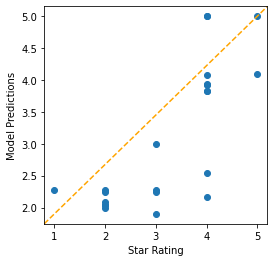

In [21]:
pipe6 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('ada', AdaBoostRegressor())])
param6 = [
    {'ada__n_estimators':[50, 100, 500]}
]
grid6 = GridSearchCV(pipe6, param6, n_jobs = -1)
grid6.fit(X_train, y_train)
print_results(grid6, X_train, X_test, y_train, y_test)

<br><br>

### Support Vector Regressor Model

#### Was only able to get a very limited SVM to ever execute fully.

*** TRAIN set ***
Score : 0.7683970167008943
RMSE: 0.5719500099671585
MSE: 0.3271268139014327

*** TEST set ***
Score : 0.37206503254322354
RMSE: 0.8591931113845315
MSE: 0.7382128026506319

Best Params : {'svr__C': 0.01, 'svr__gamma': 0.01, 'svr__kernel': 'linear'}


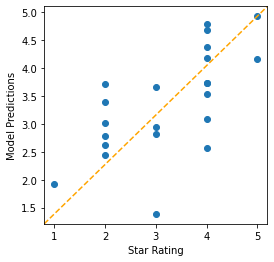

In [22]:
pipe7 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('svr', SVR())])
param7 = [
    {'svr__kernel': ['linear'],
     'svr__C': [.01, 1, 10],
     'svr__gamma': np.logspace(-2, 2, 20)
    }
#     {'svr__kernel': ['linear', 'poly'],
#      'svr__C': [.01, 1, 100],
#      'svr__gamma': np.logspace(-5, 2, 20)
#     }
]
grid7 = GridSearchCV(pipe7, param7, n_jobs = -1)
grid7.fit(X_train, y_train)
print_results(grid7, X_train, X_test, y_train, y_test)

<br><br>
<br><br>

# Regression Models (Star Score 2018-2019)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from category_encoders import OneHotEncoder 

In [24]:
data = pd.read_csv('../../01_data/cleaned_data/school_df_v6.csv')

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   code                         109 non-null    float64
 1   name                         109 non-null    object 
 2   grade_band                   109 non-null    object 
 3   enrollment_SY1718            109 non-null    float64
 4   enrollment_SY1819            109 non-null    float64
 5   star_score_SY1718            109 non-null    float64
 6   star_score_SY1819            109 non-null    float64
 7   star_rating_SY1718           109 non-null    float64
 8   star_rating_SY1819           109 non-null    float64
 9   capacity_SY1718              109 non-null    float64
 10  capacity_SY1819              109 non-null    float64
 11  latitude                     109 non-null    float64
 12  longitude                    109 non-null    float64
 13  cluster             

In [26]:
# drop unnamed columns and "bad import" full-nan rows
data = data.iloc[:,:45]
data.dropna(how='all', inplace=True)

In [27]:
# drop 2 schools that have no attendance data
data.drop(data[data['code'] == 201].index, inplace = True) # Oyster Adams Bilingual School (Adams) has no attendance data
data.drop(data[data['code'] == 347].index, inplace = True) # Brookland Middle School has no attendance data

In [28]:
# drop columns looking at "count" of absences (non-relatable across schools of different sizes)
X = data.drop(columns = data.filter(regex='^count',axis=1)).drop(columns='name')

In [29]:
# drop school_code
X.drop('code', axis = 1, inplace = True)

<br><br>

## Tailor DF to SY 1819 data

In [30]:
# drop columns looking at school year 17-18 and FY 16
X = X.drop(columns = X.filter(regex='SY1718$',axis=1)).drop(columns = data.filter(regex='FY16$',axis=1))

In [31]:
# OHE grade_band column
X_ohe = OneHotEncoder(cols=['grade_band']).fit_transform(X)

c:\programdata\miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


<br><br>

# Create no_nan_df
### Only looks at 82 rows
* Need a better solution for dealing with np.nan (originally cast as -1)

In [32]:
no_nan_df = X_ohe.replace(-1,np.nan)

In [33]:
no_nan_df.dropna(how='any',inplace=True)

In [34]:
no_nan_y = no_nan_df['star_score_SY1819']
no_nan_X = no_nan_df.drop(columns=['star_score_SY1819','star_rating_SY1819'])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(no_nan_X, no_nan_y)

<br><br>
# Regression Models

In [36]:
def print_results(grid, X_train, X_test, y_train, y_test):
    #print(f'Estimator : {grid.get_estimator_}')
    
    print('*** TRAIN set ***')
    print(f'Score : {grid.score(X_train, y_train)}')
    print(f'RMSE: {mean_squared_error(y_train, grid.predict(X_train), squared = False)}')
    print(f'MSE: {mean_squared_error(y_train, grid.predict(X_train))}')
    print()
    print('*** TEST set ***')
    print(f'Score : {grid.score(X_test, y_test)}')
    print(f'RMSE: {mean_squared_error(y_test, grid.predict(X_test), squared = False)}')
    print(f'MSE: {mean_squared_error(y_test, grid.predict(X_test))}')
    print()
    print(f'Best Params : {grid.best_params_}')

    y_pred = grid.predict(X_test)
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.scatter(y_test, y_pred)
    ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")
    #plt.title('')
    plt.xlabel('Star Rating')
    plt.ylabel('Model Predictions');

<br><br>

### Multiple Linear Regression Model

*** TRAIN set ***
Score : 1.0
RMSE: 6.047119569474466e-14
MSE: 3.6567655087521046e-27

*** TEST set ***
Score : -19.71083704458932
RMSE: 113.69463450940489
MSE: 12926.469916227163

Best Params : {'lr__normalize': 'True'}


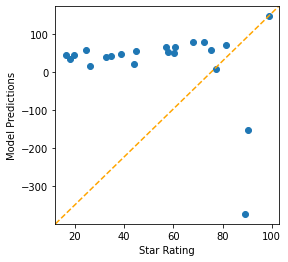

In [37]:
pipe = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('lr', LinearRegression())])
param = [
    {'lr__normalize': ['True','False']}
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)

<br><br>

### Ridge Model

*** TRAIN set ***
Score : 0.7930741844827779
RMSE: 9.842967178695208
MSE: 96.8840028808711

*** TEST set ***
Score : 0.6049134744616741
RMSE: 15.703167140660412
MSE: 246.58945824751692

Best Params : {'ridge__alpha': 100}


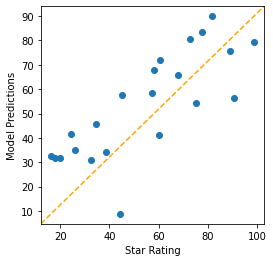

In [38]:
pipe1 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('ridge', Ridge())])
param1 = [
    {'ridge__alpha': [.01, .1, 1, 10, 100]}
]
grid1 = GridSearchCV(pipe1, param1, n_jobs = -1)
grid1.fit(X_train, y_train)
print_results(grid1, X_train, X_test, y_train, y_test)

<br><br>

### KNeighbors Model

*** TRAIN set ***
Score : 0.6003521013479312
RMSE: 13.679098162935544
MSE: 187.11772655122655

*** TEST set ***
Score : 0.5957546609473147
RMSE: 15.884138116024921
MSE: 252.30584368895572

Best Params : {'knearest__n_neighbors': 11}


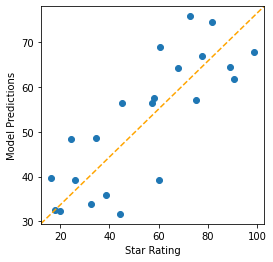

In [39]:
pipe2 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('knearest', KNeighborsRegressor())])
param2 = [
    {'knearest__n_neighbors': [3,7,11,25,35]}
]
grid2 = GridSearchCV(pipe2, param2, n_jobs = -1)
grid2.fit(X_train, y_train)
print_results(grid2, X_train, X_test, y_train, y_test)

<br><br>

### Decision Tree Model

*** TRAIN set ***
Score : 0.667709540172579
RMSE: 12.473192806473772
MSE: 155.58053878746907

*** TEST set ***
Score : 0.5705587440929484
RMSE: 16.371671663826376
MSE: 268.03163306813553

Best Params : {'dtree__ccp_alpha': 100, 'dtree__max_depth': 3, 'dtree__min_samples_leaf': 3, 'dtree__min_samples_split': 5}


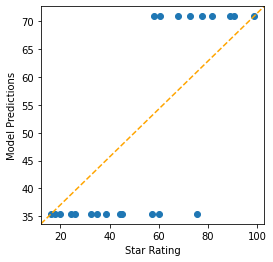

In [40]:
pipe3 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('dtree', DecisionTreeRegressor())])
param3 = [
    {'dtree__max_depth':[3,5,7,9],
    'dtree__min_samples_split':[3,5,7,9], 
    'dtree__min_samples_leaf':[3,5,7,9], 
    'dtree__ccp_alpha':[.01, .1, 1, 10, 100]}
]
grid3 = GridSearchCV(pipe3, param3, n_jobs = -1)
grid3.fit(X_train, y_train)
print_results(grid3, X_train, X_test, y_train, y_test)

<br><br>

### Bagged Decision Tree Model

*** TRAIN set ***
Score : 0.9544891037293212
RMSE: 4.616112594342857
MSE: 21.30849548365074

*** TEST set ***
Score : 0.7107895682172081
RMSE: 13.435323284857573
MSE: 180.5079117686361

Best Params : {'btree__n_estimators': 100}


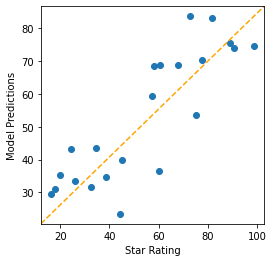

In [41]:
pipe4 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('btree', BaggingRegressor())])
param4 = [
    {'btree__n_estimators':[50, 100, 500]}
]
grid4 = GridSearchCV(pipe4, param4, n_jobs = -1)
grid4.fit(X_train, y_train)
print_results(grid4, X_train, X_test, y_train, y_test)

<br><br>

### Random Forest Model

*** TRAIN set ***
Score : 0.8564360368342397
RMSE: 8.198632477561112
MSE: 67.21757450211986

*** TEST set ***
Score : 0.7578313700767675
RMSE: 12.294194694899735
MSE: 151.14722319610078

Best Params : {'randforest__max_depth': 7, 'randforest__min_samples_leaf': 7, 'randforest__min_samples_split': 3, 'randforest__n_estimators': 50}


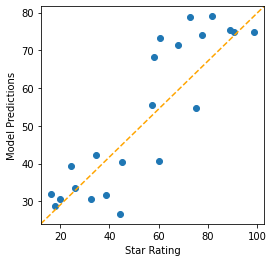

In [42]:
pipe5 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('randforest', RandomForestRegressor())])
param5 = [
    {'randforest__max_depth':[3,5,7,9],
    'randforest__min_samples_split':[3,5,7,9], 
    'randforest__min_samples_leaf':[3,5,7,9], 
    'randforest__n_estimators':[50, 100, 500]}
]
grid5 = GridSearchCV(pipe5, param5, n_jobs = -1)
grid5.fit(X_train, y_train)
print_results(grid5, X_train, X_test, y_train, y_test)

<br><br>

### Adaboost Model

*** TRAIN set ***
Score : 0.9690578776094588
RMSE: 3.8062187912577
MSE: 14.48730148692323

*** TEST set ***
Score : 0.7360782526851932
RMSE: 12.834493460004019
MSE: 164.72422237488595

Best Params : {'ada__n_estimators': 500}


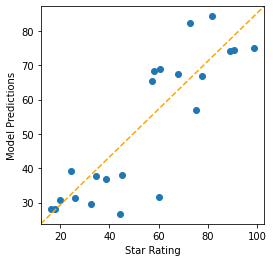

In [43]:
pipe6 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('ada', AdaBoostRegressor())])
param6 = [
    {'ada__n_estimators':[50, 100, 500]}
]
grid6 = GridSearchCV(pipe6, param6, n_jobs = -1)
grid6.fit(X_train, y_train)
print_results(grid6, X_train, X_test, y_train, y_test)

<br><br>

### Support Vector Regressor Model

#### Was only able to get a very limited SVM to ever execute fully.

*** TRAIN set ***
Score : 0.6326903142610244
RMSE: 13.113991248568135
MSE: 171.97676646752166

*** TEST set ***
Score : 0.5820837807701998
RMSE: 16.1504920104094
MSE: 260.83839217829785

Best Params : {'svr__C': 0.01, 'svr__gamma': 0.01, 'svr__kernel': 'linear'}


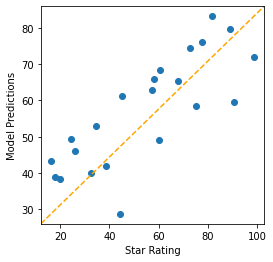

In [44]:
pipe7 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('svr', SVR())])
param7 = [
    {'svr__kernel': ['linear'],
     'svr__C': [.01, 1, 10],
     'svr__gamma': np.logspace(-2, 2, 20)
    }
#     {'svr__kernel': ['linear', 'poly'],
#      'svr__C': [.01, 1, 100],
#      'svr__gamma': np.logspace(-5, 2, 20)
#     }
]
grid7 = GridSearchCV(pipe7, param7, n_jobs = -1)
grid7.fit(X_train, y_train)
print_results(grid7, X_train, X_test, y_train, y_test)